# Frank-Wolfe approach to boosting algorithms

In [141]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import Line2D
from pandas import DataFrame
from time import process_time
from enum import Enum
from typing import Union
import math
from sklearn.model_selection import KFold
import statistics
from typing import Optional

In [142]:
!pip install pulp
from pulp import *

### Loading dataset

In [225]:
row_data = load_breast_cancer()
data = pd.DataFrame(data=row_data.data, columns=row_data.feature_names)
X = data.values
data['y']= row_data.target
y = data.y
data.loc[y==0,'y']=-1 #changing the labels of class 0 in -1
print("Num of examples:",data.shape[0])
print("Num of features:",data.shape[1])

Num of examples: 569
Num of features: 31


### How the dataset looks like

In [226]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,-1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,-1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,-1


### Train-test split

In [227]:
y = np.array(data['y'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123) #the test set is the 20% of the entire dataset
data_train = pd.DataFrame(X_train)
data_train['y']=y_train
data_test = pd.DataFrame(X_test)
data_test['y']= y_test

### Building as base learner a DecisionTree classifier
#### Building blocks: splitting rule, branch and leaves nodes

In [228]:
#Definition of Splitter class
class Splitter:
    def __init__(self, feature: int, threshold: float):

        self.feature = feature #integer of the feature to use to split

        self.threshold = threshold #corresponding threshold

    def split(self, data: DataFrame, row: int):
        num = self.feature #corresponding number of the feature
        value = data.loc[row, num] #extract the value of the selected row

        #Directing the instance in the correct path
        if value < self.threshold:
            return "Left"
        else:
            return "Right"


#Definition of Node class
class Node:
  """The predict method will be defined differently depending on the type of the node:
   - if the node is a leaf it will return the predicted label
   - if the node is a branch node it will navigate the DecisionTree pointing to the
    corresponding branch"""
  def predict(self,data:DataFrame,row:int):
    pass

class BranchNode(Node):
  def __init__(self, rule: Splitter, left: Union['BranchNode', 'LeafNode'], right: Union['BranchNode', 'LeafNode'],total_weight:float,loss_as_leaf:float):
        #splitting rule
        self.rule = rule

        #left child
        self.left = left

        #right child
        self.right = right

        #sum of the samples' weights contained in the node
        self.total_weight=total_weight

        #error made if the node is considered a leaf
        self.loss_as_leaf=loss_as_leaf

  def predict(self,data:DataFrame, row: int):

    split_result=self.rule.split(data,row)
    if split_result=="Left":
      return self.left.predict(data,row)
    else:
      return self.right.predict(data,row)

class LeafNode(Node):
  def __init__(self, prediction: float,total_weight,loss):

        #label predicted associated to the leaf
        self.prediction = prediction

        #sum of the samples' weights contained in the leaf
        self.total_weight = total_weight

        #error made
        self.loss = loss

  def predict(self,data:DataFrame,row:int):
    return self.prediction




### Build the decision tree

Relation between the error and the edge in a binary classification problem

$\epsilon_{\mathrm{h}}(\mathrm{d})=\frac{1}{2}-\frac{1}{2} \gamma_{\mathrm{h}}$        (1)

In [229]:
# Definition of DecisionTree classifier
class DecisionTreeClassifier():
  def __init__(self,min_samples_split=2,max_depth=None):
    #Initialisation
    self.root=None

    #Stopping conditions
    self.min_samples_split=min_samples_split
    self.max_depth=max_depth

  def build_tree(self,data,d,curr_depth=0):

    data['d'] = d
    m, n = data.shape
    tot_weight = sum(data['d'])
    pred,loss = self.compute_loss(data)
    if loss==0.0 or m<self.min_samples_split or (self.max_depth is not None and curr_depth > self.max_depth-1):
      return LeafNode(pred,tot_weight,loss)
    #Find the best split that maximizes the edge
    feature_index, best_threshold=self.find_best_split(data)
    rule = Splitter(feature_index,best_threshold)

    lindices = []
    rindices = []
    for i in data.index:
      split = rule.split(data, i)
      if split == "Left":
        lindices.append(i)
      elif split == "Right":
        rindices.append(i)
      else:
        raise ValueError("Invalid split value")
    if lindices==[] or rindices==[]:
      pred,loss = self.compute_loss(data)
      return LeafNode(pred,tot_weight,loss)
    ltree = None
    rtree = None
    columns_to_select = data.columns.tolist()[:-1] #data_train
    data_left = data.loc[lindices,columns_to_select]
    data_right = data.loc[rindices,columns_to_select]
    dist_left = data.loc[lindices,'d']
    dist_right = data.loc[rindices,'d']
    if self.max_depth == 1:
      # the childs from this node must be leaves
      data_left['d']= dist_left
      data_right['d']= dist_right
      ltree = self.create_leaf(data_left)
      rtree = self.create_leaf(data_right)
    else:
      # the childs from this node might be branches.
      ltree = self.build_tree(data_left,dist_left, curr_depth+1)
      rtree = self.build_tree(data_right, dist_right, curr_depth+1)
    return BranchNode(rule, ltree, rtree, tot_weight, loss)


  def create_leaf(self,data):
    (pred, loss) = self.compute_loss(data)
    total_weight = sum(data['d'])
    return LeafNode(pred, total_weight, loss)


  """This method compute the class which has the biggest sum of samples'
  weights in a node and the corresponding loss. It returns the best prediction
  that minimizes the error on the node"""
  def compute_loss(self,data):
    counter = {-1:0,1:0} #dictionary containing the sum of samples' weights of
                         #each class
    m = data.shape[0]
    d = data['d'].values
    y = data['y'].values
    for i in range(m):
      key = y[i]
      counter[key] += d[i]
    tot= sum(counter.values()) #total_weight in the node
    #class with the Biggest Sum of the samples' Weights
    bsw_class = max(counter,key=counter.get)
    p = counter[bsw_class] #weight value of the "most weighted" class
    if tot > 0.0:
      node_err= tot * (1.0 - (p/tot)) #scaled error
    else:
      node_err=0.0
    return bsw_class,node_err



  """find_best_split finds the split that maximizes the edge: it compares the splits
  for all the features and for all possible thresholds and picks the best """
  def find_best_split(self,data):

    feature = None
    threshold = None
    m,n = data.shape
    d = data['d'].values
    y = data['y'].values
    edges =[]
    thr_list=[]
    for col in range(n-2): #the last two columns contain the target and the distribution d
      col_values = data.iloc[:,col].values
      #triplets containing the value of a feature, the weight and the target for a specific instance
      triplets = [[col_values[i], d[i], y[i]] for i in range(m)]
      triplets.sort(key=lambda x: x[0])
      # Initial threshold: smallest value of the feature -1
      best_threshold = triplets[0][0] - 1.0
      # Initial edge: predict +1 for all instances
      edge = sum(d * y for _, d, y in triplets)
      best_edge = abs(edge)
      for index,trio in enumerate(triplets):
          i = index
          left = trio[0]
          #we consider each instance as a point of class -1,
          #so a missclassified point and decrement the edge
          #according to (1)
          edge -= 2.0 * trio[1] * trio[2]
          try:
            next = triplets[i+1]
            xx, dd, yy = next
          except:
            #the biggest threshold considered is the left-most point +1
            right = left + 1.0
          if i != m-1:
            right = next[0]
          #possible thresholds are all the mean values between two occurrences
          threshold = (left + right) / 2.0
          if abs(edge) > best_edge:
              best_edge = abs(edge)
              best_threshold = threshold
      edges.append(best_edge)
      thr_list.append(best_threshold)
    feature_index = edges.index(max(edges))
    best_edge= max(edges)
    best_threshold= thr_list[feature_index]
    return feature_index, best_threshold


  #Build the tree and return the root node
  def fit(self,data,d):
    self.root = self.build_tree(data,d)
    return self.root


  # def print_tree(self, node=None, indent=""):
  #       if node is None:
  #           node = self.root

  #       if isinstance(node, LeafNode):
  #           print(indent + "Leaf Node - Prediction:", node.prediction)
  #       elif isinstance(node, BranchNode):
  #           print(indent + "Branch Node - Splitting on Feature", node.rule.feature, "Threshold:", node.rule.threshold)
  #           print(indent + "Left Subtree:")
  #           self.print_tree(node.left, indent + "  ")
  #           print(indent + "Right Subtree:")
  #           self.print_tree(node.right, indent + "  ")

### LPBoost
We want to solve the following linear programming problem


$\begin{array}{r}\gamma_t^*(\nu)=\min _{\mathbf{d}, \gamma} \gamma \\ \text { s.t. } \mathbf{d} \cdot \mathbf{u}^m \leq \gamma, \text { for } 1 \leq m \leq t \\ \mathbf{d} \in \mathcal{P}^N, \mathbf{d} \leq \frac{1}{\nu} 1\end{array}$

In [230]:
class LPModel:
  def __init__(self,size,upper_bound):
    self.model = LpProblem(name = "LpProblem",sense=LpMinimize)
    self.size = size
    self.gamma = LpVariable(name="gamma")
    self.model += self.gamma, "Objective"
    self.dist = [LpVariable(name= "d[{}]".format(i),lowBound=0.0,upBound=upper_bound) for i in range(self.size)] #samples' distribution

    #sum of samples' weights is 1
    constraint1 = LpConstraint(sum(self.dist), sense=LpConstraintEQ, rhs=1.0)
    self.model.addConstraint(constraint1)
    self.constrs=[constraint1]


  def update(self,data:DataFrame,target,clf):
    pred = [y * clf.predict(data, i) for i, y in enumerate(target)]

    #current edge constraint
    constraint = lpSum(d * yh for d, yh in zip(self.dist, pred)) <= self.gamma
    self.model += constraint
    self.constrs.append(constraint)

    self.model.solve()

    status = LpStatus[self.model.status]
    if status!='Optimal':
      raise Exception
    optimal_gamma = self.gamma.varValue
    return optimal_gamma


  def distribution(self):
    return [var.varValue for var in self.dist]

  def weight(self):
    #the weights of the hypotheses are the Langrange multipliers of the constraints
    return [abs(constr.pi) for constr in self.constrs[1:]]


Prediction of the final classifier

$f_w\left(x_i\right)=\sum_{t=1}^T w_t h_t\left(x_i\right)$

In [231]:
class FinalClassifier:
  def __init__(self,tuples_list):
    self.tuples_list = tuples_list

  def predict(self,data,row):
    return sum(w*h.predict(data,row) for w,h in self.tuples_list)

The goal is to solve the edge minimization problem

$$
\min _{\boldsymbol{d}} \max _{\boldsymbol{j} \in [n]}(d^{T}A)_j + f(d)
$$
By Fenchel duality
$$
\max _{\boldsymbol{w} \in \mathcal{P}^n}-f^{\star}(-A \boldsymbol{w})
$$

When we want to compute the objective function to maximize $-f^{\star}(-A\boldsymbol{w})$ we know that

$$f^{\star}(-A \boldsymbol{w})=\sup _{\boldsymbol{d}}\left[-\boldsymbol{d}^{\top} A \boldsymbol{w}-f(\boldsymbol{d})\right]=\max _{\boldsymbol{d} \in \mathcal{P}_\nu^m}-\boldsymbol{d}^{\top} A \boldsymbol{w}= - \min _{\boldsymbol{d} \in \mathcal{P}_\nu^m}\boldsymbol{d}^{\top} A \boldsymbol{w}$$


Therefore, to compute the objective function we should minimize the inner product between $d^T$ and $Aw$

To minimize the inner product we should allocate the greatest admissible weight of $d$ to the smallest element of $Aw$, allocate the greatest of the remaining weights to the second smallest element of $Aw$, and so on and so forth

In [232]:
class LPBoost:
  def __init__(self,data,nu):
    size, _ = data.shape
    assert size != 0
    uni= 1.0/size
    self.dist = [uni] * size #initial uniform distribution
    self.gamma_hat = 1.0
    self.eps = uni #tolerance parameter
    self.size = size
    self.nu = nu #capping parameter: number of presumed outliers
    self.lp_model = None

  def set_nu(self, nu):
    assert 1.0 <= nu <= self.size
    self.nu = nu

  def set_tolerance(self, tolerance):
        self.eps = tolerance

  def init_solver(self):
    upper_bound = 1.0/self.nu
    assert 0 <= upper_bound <= 1.0

    self.lp_model = LPModel(self.size, upper_bound)

  def update_distribution(self,data,target,h:Node):
    if self.lp_model is not None:
      return self.lp_model.update(data,target,h)
    else:
      raise ValueError("Lp_model not initialised")

  def LPboost_alg(self,data_train,data_test,target,eps):

    self.set_tolerance(eps)
    self.init_solver()
    classifiers=[]
    times=[]
    err_test =[]
    obj_f=[]
    weights=[]
    num_iter= 100
    self.terminated = float('inf')

    start = process_time()

    for index in range(num_iter):
      #Obtaining a new base learner
      base_learner = DecisionTreeClassifier(max_depth=1)
      h = base_learner.fit(data_train,self.dist)

      #current edge of the learner
      ghat = sum(y* h.predict(data_train,i)* d for i,(y,d) in enumerate(zip(target,self.dist)))
      self.gamma_hat = min(ghat, self.gamma_hat) #minimum between all the edges of the base learners
      #Solving the LP problem
      gamma_star=self.update_distribution(data_train,target,h)

      classifiers.append(h)

      #Stopping condition:
      #the training error of the final classifier is less than epsilon
      if gamma_star >= self.gamma_hat - self.eps:
        self.terminated= len(classifiers)
        break

      #Update the samples' distribution
      self.dist = self.lp_model.distribution()

      times.append(process_time() - start)

      weights = self.lp_model.weight()
      obj_f.append(self.lp_objval(data_train, target, weights, classifiers, self.nu))
      err_test.append(self.loss(data_test,classifiers,weights))

    #build the final classifier
    clfs_weights = [(w,clf) for w,clf in zip(weights,classifiers) if w!=0]

    final_classifier = FinalClassifier(clfs_weights)

    return final_classifier,times, err_test, obj_f

  #loss method returns the proportion of the missclassified points
  def loss(self,data,classifiers,weights):
    y = data['y']
    err=0.0
    size = data.shape[0]
    for i in range(size):
        pred = self.final_pred(i,data,classifiers,weights)
        if pred*y[i]<=0.0:
          err +=1.0

    return err/size

  #final prediction on a instance: sum of the weighted predictions
  def final_pred(self,i, data, classifiers, weights):
    return sum(w * h.predict(data, i) for h, w in zip(classifiers, weights))

  #Computing the objective function value
  #-f*(-Aw) = min(d^T*A*w)
  def lp_objval(self,data, target, weights, classifiers, nu):
      m = data.shape[0]

      margins = [y * self.final_pred(i, data, classifiers, weights)for i, y in enumerate(target)]


      #We extract the indices in ascending order for the margin: the first element
      #will be the one worst classified (a large negative margin)
      indices = np.argsort(margins)
      total = 1.0
      max_weight = 1.0 / nu


      """We create a distribution where we give more weights to the worst examples
      in such a way to attribute the max_weight to the worst sample and then
      the other weights to the following samples contained in indices.
      We give more weights to the wrong samples and in this way we are creating a
      distribution that miminizes d^T*A*w = -f*(-Aw)"""
      dist = np.zeros(m)

      for i in indices:
          if max_weight <= total:
              dist[i] = max_weight
              total -= max_weight
          else:
              dist[i] = total
              break

      assert all(0.0 <= d <= 1.0 for d in dist)
      assert abs(1.0 - np.sum(dist)) < 1e-6

      objval = np.sum(dist * np.array(margins))

      return objval


### Cross validation for the capping hyperparameter $v$

In [239]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
X = data_train.iloc[:,:-2].values
y = data_train['y']
size = data_train.shape[0]/5
errors={}
errors_split=[]
v_values=np.array([0.1,0.2,0.3,0.4,0.5])
for v in v_values:
  for train_index, test_index in kf.split(X,y):
    train_index = np.array(train_index, dtype=int)
    test_index = np.array(test_index, dtype=int)

    X_tr_selected = X[train_index]
    y_tr_selected = y[train_index]
    X_test_selected = X[test_index]
    y_test_selected = y[test_index]

    data = pd.DataFrame(X_tr_selected)
    data['y'] = y_tr_selected.reset_index(drop=True)

    data_t = pd.DataFrame(X_test_selected)
    data_t['y'] = y_test_selected.reset_index(drop=True)

    LP_boost = LPBoost(data, nu = v*size)
    final_classifier, times, err_test, obj_f = LP_boost.LPboost_alg(data,data_t, y_tr_selected,eps= 0.01)
    errors_split.append(err_test[-1])
  errors[v] = statistics.mean(errors_split)
best_v = min(errors, key = lambda k: errors[k])
print("The best v value for this dataset is: ", best_v)



The best v value for this dataset is:  0.1


In [233]:
#best_v=0.1
Lp_boost = LPBoost(data_train,nu=data_train.shape[0]*best_v)
final_classifier_lp, times_lp, err_test_lp, obj_f_lp = Lp_boost.LPboost_alg(data_train,data_test, list(data_train['y']),eps= 0.01)

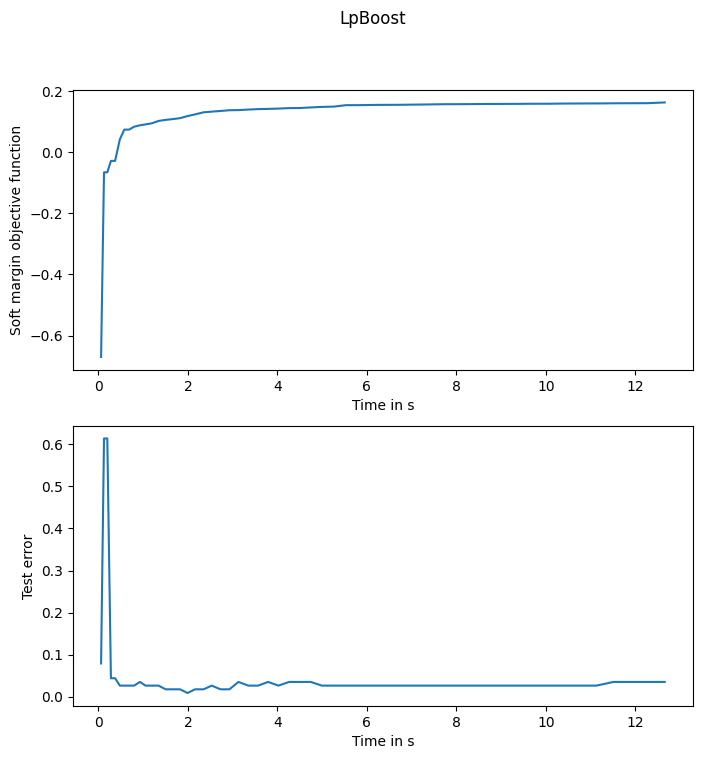

In [234]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(times_lp,obj_f_lp)
axs[1].plot(times_lp,err_test_lp)

axs[0].set_xlabel('Time in s')
axs[0].set_ylabel('Soft margin objective function')

axs[1].set_xlabel('Time in s')
axs[1].set_ylabel('Test error')

fig.suptitle('LpBoost')
plt.show()

# Modified LPBoost

In [235]:
from pulp import *
class LPmodel_MLPB:
  def __init__(self,size,upper_bound):
    self.model = LpProblem(name = "LpProblem",sense=LpMinimize)
    self.size = size
    self.gamma = LpVariable(name="gamma",lowBound=None)
    self.model += self.gamma, "Objective"
    self.dist = [LpVariable(name= "d[{}]".format(i),lowBound=0.0,upBound=upper_bound) for i in range(self.size)]

    constraint1 = LpConstraint(sum(self.dist), sense=LpConstraintEQ, rhs=1.0)
    self.model.addConstraint(constraint1)
    self.constrs=[constraint1]


  def update(self,data:DataFrame,target,clf):
    if clf is not None:
        edge = [y * clf.predict(data, i) for i, y in enumerate(target)]
        #current edge constraint
        constraint = lpSum(d * yh for d, yh in zip(self.dist, edge)) <= self.gamma
        self.model += constraint

        self.constrs.append(constraint)

        self.model.solve()

        status = LpStatus[self.model.status]
        if status!='Optimal':
          raise Exception
    return [abs(constr.pi) for constr in self.constrs[1:]]

### Sorting-based algorithm for finding $d_{t}$

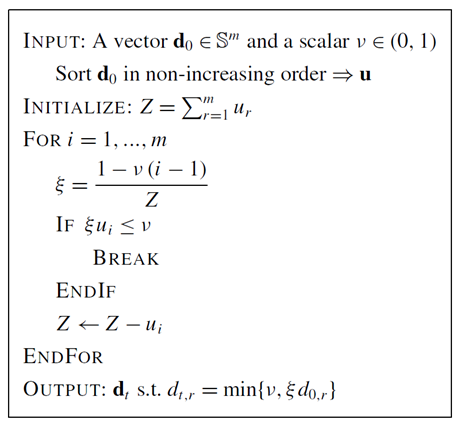

Initial distribution  

$d_{t, 0} \propto e^{-\eta\left(A w_t\right)_i}$

The main problem of this algorithm is that we should compute the normalization
term Z = $\sum_{i=1}^m e^{d_i}$ and this computation leads to overflow. Fix $i, j \in[m]$. Without loss of generality, we can assume that $d_i \leq d_j$
 since we have sorted the distribution in a non-increasing order. It's possible to prove that $\ln \left(e^{d_i}+e^{d_j}\right)=$ $d_j+\ln \left(1+e^{d_i-d_j}\right)$. Repeating this procedure, we can compute $\ln \sum_{i=1}^m e^{d_i}$ with avoiding overflow

Since we are computing the logsums, we should also compute the log of the xi constant
 $$
\xi=\frac{1-v(i-1)}{Z}
$$ that is

$$ \ln(\xi)=\ln{(1-v(i-1))}- ln{(Z)}$$ where $ln{(Z)}$ coincides with the logsum previously computed

Also for the stopping condition:
$\xi u_i \leq v$ we take the log of both sides.

Therefore, it becomes:

$ln(\xi) + ln(u_i) \leq ln(v)$

$ln(\xi) -\eta\left(A w_t\right)_i - ln(v) \leq 0$




### Frank-Wolfe strategies
$\widehat{x}_{t+1}=x_t+\lambda_t\left(\hat{x}_t-x\right)$ =  $\boldsymbol{w}_{t+1}^{(1)}=\boldsymbol{w}_t+\lambda_t\left(\boldsymbol{e}_{j_{t+1}}-\boldsymbol{w}_t\right)$ where $\boldsymbol{e}_{j_{t+1}}$ correspond to the a vector that contains as many zeros as the number of base learners, but the $j+1$ position that is equal to 1


#### Classic Frank-Wolfe
$\lambda_t=\frac{2}{t+2}$.

#### Short-step strategy
 $\lambda_t= \max \left\{0, \min \left\{1, \frac{\left(x_t-x_{t+1}\right)^T \nabla \mathrm{f}\left(x_t\right)}{\eta\left\|x_{t+1}-x_t\right\|^2}\right\}\right\} =
 \operatorname{clip}_{[0,1]} \frac{\boldsymbol{d}_t^{\top} A\left(\boldsymbol{e}_{j+1}-\boldsymbol{w}_t\right)}{\eta\left\|A\left(\boldsymbol{e}_{j+1}-\boldsymbol{w}_t\right)\right\|_{\infty}^2}$

#### Main steps of the Away-step strategy
Let $d_t^{\mathrm{FW}}=s_t-x^{(t)} \quad = A\boldsymbol{e}_{j+1}  - Aw_{t}$  (the FW direction)

and $d_t^{\mathrm{A}}=x^{(t)}-v_t \quad = Aw_{t} - A\boldsymbol{e}_{away learner} $  (the away direction)

Taking into account that f is a convex function and that $\nabla f\left(-x^{(t)}\right)= \nabla f(-Aw_{t}) =  d_{t}$

The if-condition

$\left\langle-\nabla f\left(x^{(t)}\right), d_t^{\mathrm{FW}}\right\rangle
\geq\left\langle-\nabla f\left(x^{(t)}\right), d_t^{\mathrm{A}}\right\rangle$

becomes

$\left\langle d_{t}, d_t^{\mathrm{FW}}\right\rangle
\geq\left\langle d_{t}, d_t^{\mathrm{A}}\right\rangle$

$\left\langle d_{t}, A\boldsymbol{e}_{j+1}  - Aw_{t}\right\rangle
\geq\left\langle d_{t}, Aw_{t} - A\boldsymbol{e}_{away learner}\right\rangle$

Therefore, we can work with the edges and the margins.


When we choose the FW-direction
$d_t:=d_t^{\mathrm{FW}}= A(\boldsymbol{e}_{j+1}  - w_{t})$, we set $\gamma_{\max }:=1 \quad$

while when we choose the Away direction

$\boldsymbol{d}_t:=A(w_{t} - \boldsymbol{e}_{away learner})$, we set $\gamma_{\max }:=\alpha_{\boldsymbol{v}_t} /\left(1-\alpha_{\boldsymbol{v}_t}\right) \quad$

then perform the line-search:

$\gamma_t \in \underset{\gamma \in\left[0, \gamma_{\max }\right]}{\arg \min } f\left(\boldsymbol{x}^{(t)}+\gamma \boldsymbol{d}_t\right)$

and update

$\boldsymbol{x}^{(t+1)}:=\boldsymbol{x}^{(t)}+\gamma_t \boldsymbol{d}_t$


### Stopping condition of MLPBoost
Obtimality gap:  $\epsilon_t:=\min _{0 \leq \tau \leq t}\left(\boldsymbol{d}_\tau^{\top} A\right)_{j_{\tau+1}}+\tilde{f}^{\star}\left(-A \boldsymbol{w}_t\right)$

If $\eta=2 \ln (m / \nu) / \epsilon$,

then $\epsilon_t \leq \epsilon / 2$ implies $-f^{\star}\left(-A w_t\right) \geq g-\epsilon$.

In [164]:
#Frank-Wolfe strategies
class MLPBoost:
    def __init__(self, df):
        size = df.shape[0]
        assert size != 0
        uni = 1.0 / float(size)

        half_tolerance = 0.005
        nu = 1.0
        eta = math.log(size/ nu) / half_tolerance #regularised parameter

        self.max_iter=100
        self.eta = eta
        self.size = size
        self.half_tolerance = half_tolerance
        self.nu = nu
        self.lp_model = None
        self.weights = []
        self.gamma = 1.0


    def set_nu(self, nu):
        assert 1.0 <= nu <= float(self.size)
        self.nu = nu
        self.regularization_param()


    def regularization_param(self):
        ln_part = math.log(float(self.size) / self.nu)
        self.eta = ln_part / self.half_tolerance


    def init_solver(self):
        upper_bound = 1.0 / self.nu
        assert 0.0 <= upper_bound <= 1.0
        self.lp_model = LPmodel_MLPB(self.size, upper_bound)

    #number of LPBoost calls
    def get_lpb_call(self):
        return self.lpb_call

    def final_pred(self, i: int, data: pd.DataFrame, classifiers, weights):
        result = sum(w * h.predict(data, i) for h, w in zip(classifiers, weights))
        return result

    #Computing the objective function value
    #-f_tilde*(-Aw) = d^T*A*w + 1/eta * relative_entropy
    def objval(self, data: pd.DataFrame, target: pd.Series, classifiers, weights):
        dist = self.w_samples(data, target, classifiers, weights)
        weighted_margin = self.payoff(data, target, dist, classifiers, weights) #d^T*A*w

        entropy = sum(d * math.log(d) if d != 0.0 else 0.0 for d in dist) + math.log(self.size)

        return weighted_margin + (entropy/self.eta)

    #d^T*A*w
    def payoff(self, data: pd.DataFrame, target: pd.Series, dist, classifiers, weights):
        return sum(d * float(y) * self.final_pred(i, data, classifiers, weights) for i, (d, y) in enumerate(zip(dist, target)))

    # Compute the exponent of d_t,0
    def exp_dt(self, data: pd.DataFrame, target: pd.Series, classifiers, weights):
        exp = np.array([-self.eta * y * self.final_pred(i, data, classifiers, weights) for i, y in target.items()])
        return exp


    def projection(self, dist):
        size = len(dist)


        # Sort the indices of the distribution in decreasing order.
        ix = list(range(size))
        ix.sort(key=lambda i: dist[i], reverse=True)


        dist = list(dist)

        logsums = [] #this contains the logsums relative to two successive
                     #samples' weights
        prev_logsum = None
        #This procedure computes ln(e^d_i + e^d_j) = d_j  + ln(1 + e^(d_i-d_j))
        for i in reversed(ix):
            if prev_logsum is not None:
                di = min(prev_logsum, dist[i])
                dj = max(prev_logsum, dist[i])
                logsum = dj + math.log(1.0 + math.exp(di - dj))
            else:
                logsum = dist[i]
            logsums.append(logsum)
            prev_logsum = logsum

        #Reversing the logsums to have it in a non-increasing order as the list
        #of the indexes
        logsums = logsums[::-1]

        max_weight = 1.0 / self.nu
        log_cap = math.log(self.nu)

        ix_with_logsum = list(enumerate(zip(ix, logsums)))

        for i, (i_sorted, logsum) in ix_with_logsum:
            log_xi = math.log(1.0 - max_weight * i) - logsum
            current_exp = dist[i_sorted]

            #Stopping condition
            if log_xi + current_exp + log_cap <= 0.0:
                #building the distribution d_t,r = xi*d_0,r for all the weights
                #with r in the set [i,m]
                dist[i_sorted] = math.exp(log_xi + current_exp)
                for _, (ii, _) in ix_with_logsum[i+1:]:
                    dist[ii] = math.exp(log_xi + dist[ii])
                break

            #all the previous sample weights are equal to the maximum possible
            #weight 1/nu
            dist[i_sorted] = max_weight

        return dist

    def loss(self,data,classifiers,weights):
      y = data['y']
      err=0.0
      size = data.shape[0]
      for i in range(size):
          pred = self.final_pred(i,data,classifiers,weights)
          if pred*y[i]<=0.0:
            err +=1.0

      return err/size

    def w_samples(self, data: pd.DataFrame, target: pd.Series, classifiers, weights):
        dist = self.exp_dt(data, target, classifiers, weights)
        return self.projection(dist)

    #Computing the samples' weights according to LPBoost
    def lpb_weight(self, data: pd.DataFrame, target: pd.Series, opt_h):
        lp_model = self.lp_model
        if lp_model is None:
            raise ValueError("lp_model is not initialized")

        return lp_model.update(data, target, opt_h)

    #Computing the samples' weights according to Frank-Wolfe
    def fw_weight(self, data: pd.DataFrame, target: pd.Series, dist, position: int, classifiers, weights, edge_of_h: float, iteration: int, strategy):
        if strategy == "Classic":
            return self.classic_weight(position, 2/(iteration+2), weights)
        elif strategy == "ShortStep":
          return self.shortstep_weight(data, target, dist, position, classifiers, weights)
        else: #Away-step strategy
            return self.awaystep_weight(data, target, dist, position, classifiers, weights, edge_of_h)


    def classic_weight(self, index, lambda_value, weights):
      for i in range(len(weights)):
          e = 1.0 if index == i else 0.0
          weights[i] = weights[i] + lambda_value * (e - weights[i]) #lambda_value * e + (1.0 - lambda_value) * weights[i]

      return weights


    def shortstep_weight(self, data, target, dist, index, classifiers, weights):
      if len(classifiers) == 1:
          return [1.0]

      new_h = classifiers[index]

      num = 0.0
      den = float('-inf')

      for i, (y, d) in enumerate(zip(target, dist)):
          new_p = new_h.predict(data, i)
          old_p = self.final_pred(i, data, classifiers, weights)

          diff = y* (new_p - old_p)
          den = max(den, abs(diff))

          num += d * diff

      step = num / self.eta * den**2
      lambda_value = max(0.0, min(1.0,step))

      return self.classic_weight(index, lambda_value, weights)


    def awaystep_weight(self, data: pd.DataFrame, target: pd.Series, dist, index: int, classifiers, weights, fw_edge: float):

      enum_classifiers = [(i, h) for i, h in enumerate(classifiers) if weights[i] > 0.0]
      #Finding the worst classifier that gives us the away_edge and the corresponding index away_ix
      away_ix, away_learner = min(enum_classifiers, key=lambda x: sum(d * float(y) * x[1].predict(data, i) for i, (y, d) in enumerate(zip(target,dist))))
      away_edge = sum(d * y * away_learner.predict(data, i) for i, (y, d) in enumerate(zip(target, dist)))

      #Computing the overall margin
      margin = self.payoff(data, target, dist, classifiers, weights)


      if fw_edge - margin >= margin - away_edge:
        #better to move towards the LP solution
          direction = [-w for w in weights]
          direction[index] += 1.0
          max_stepsize = 1.0
      else:
        #better to go away from the classifier with the worst edge
          alpha = weights[away_ix] #weight of the learner with the worst edge
                                   #(the weight associated to the "vertex")
          direction = list(weights)
          direction[away_ix] = 0.0 #We cancel the effect of the worst learner
          max_stepsize = alpha / (1.0 - alpha)

      return self.linesearch_weight(data, target, weights, direction, classifiers, max_stepsize)


#Exact line search type using bisection-like method

    def linesearch_weight(self, data, target, init_weights, dir, classifiers, max_stepsize):

        lower = 0.0
        upper = max_stepsize

        tmp = [w + max_stepsize * d for w, d in zip(init_weights, dir)]
        dist = self.w_samples(data, target, classifiers, tmp) #update the samples' distribution

        margin = self.payoff(data, target, dist, classifiers, dir)

        if margin >= 0.0:
            weights = [w + max_stepsize * d for w, d in zip(init_weights, dir)]
            return weights

        while 10.0 * (upper - lower) > self.half_tolerance*2:
            stepsize = (lower + upper) / 2.0

            tmp = [w + stepsize * d for w, d in zip(init_weights, dir)]
            dist = self.w_samples(data, target, classifiers, tmp)

            margin = self.payoff(data, target, dist, classifiers, dir)

            if margin > 0.0:
                lower = stepsize
            elif margin < 0.0:
                upper = stepsize
            else:
                break

        stepsize = (lower + upper) / 2.0

        weights = [w + stepsize * d for w, d in zip(init_weights, dir)]
        return weights



    def run(self, data, target, data_test, fw_strategy, fw_only):
        self.init_solver()


        times=[]
        err_test =[]
        obj_f=[]


        base_learner = DecisionTreeClassifier(max_depth=1)
        h = base_learner.fit(data, [1.0 / self.size] * self.size) #uniform distribution
        classifiers = [h]
        weights = self.lpb_weight(data, target, classifiers[-1])
        self.lpb_call = 1
        lpb_calls=[1]
        gamma = 1.0

        start= process_time()

        for iteration in range(self.max_iter):
            dist = self.w_samples(data, target, classifiers, weights)

            h = base_learner.fit(data, dist)

            edge_of_h = sum(d * y * h.predict(data, i) for i, (y, d) in enumerate(zip(target, dist)))

            gamma = min(gamma, edge_of_h)

            objval = self.objval(data, target, classifiers, weights)
            obj_f.append(objval)

            err_test.append(self.loss(data_test,classifiers,weights))

            if gamma - objval <= self.half_tolerance:
                print(f"Break loop at: {iteration}")
                times.append(process_time()-start)
                break

            opt_h = None
            #index of the new base-learner
            position = classifiers.index(h) if h in classifiers else len(classifiers)

            if position == len(classifiers):
                classifiers.append(h)
                weights.append(0.0) #initialize the weight of the new base-learner
                opt_h = classifiers[-1]

            fw_w = self.fw_weight(data, target, dist, position, classifiers, weights, edge_of_h, iteration,fw_strategy)
            if fw_only == True:
              weights= fw_w
            else:
              lpb_w = self.lpb_weight(data, target, opt_h)

              lpb_edge = self.payoff(data, target, dist, classifiers, lpb_w)
              fw_edge = self.payoff(data, target, dist, classifiers, fw_w)

              if lpb_edge > fw_edge:
                self.lpb_call += 1
                lpb_calls.append(self.lpb_call)
                weights = lpb_w
              else:
                lpb_calls.append(self.lpb_call)
                weights = fw_w
            times.append(process_time()-start)

        clfs = [(w, clf) for w, clf in zip(weights, classifiers) if w > 0.0]

        final_classifier = FinalClassifier(clfs)

        return final_classifier,times, err_test, obj_f, lpb_calls




### Comparison of LPBoost and MLPBoost

In [165]:
MLP_boost = MLPBoost(data_train)
MLP_boost.set_nu(data_train.shape[0]*best_v)

#MLPBoost with Classical Frank-Wolfe
#final_classifier_FW, times_FW, err_test_FW, obj_f_FW, lp_calls_FW = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "Classic", fw_only= False)

In [166]:
#MLPBoost with short-step strategy
final_classifier_SS, times_SS, err_test_SS, obj_f_SS, lp_calls_SS = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "ShortStep", fw_only= False)

In [167]:
#MLPBoost with Away-Step Frank-Wolfe strategy
final_classifier_AWS, times_AWS, err_test_AWS, obj_f_AWS, lp_calls_AWS = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "AwayStep", fw_only= False)

Break loop at: 53


In [173]:
#MLPBoost with Short-Step Frank-Wolfe strategy without LPBoost updates
final_classifier_SS_only, times_SS_only, err_test_SS_only, obj_f_SS_only, lp_calls_S = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "ShortStep", fw_only= True)

In [174]:
#MLPBoost with Away-Step Frank-Wolfe strategy without LPBoost updates
final_classifier_AWS_only, times_AWS_only, err_test_AWS_only, obj_f_AWS_only, lp_calls_AW = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "AwayStep", fw_only= True)

Break loop at: 68


### Objective function plots

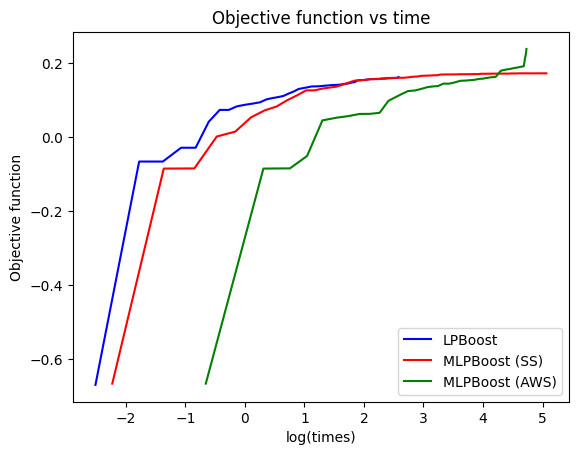

In [168]:
plt.plot(np.log(times_lp), obj_f_lp, c="blue", label="LPBoost")
plt.plot(np.log(times_SS), obj_f_SS, c="red", label ="MLPBoost (SS)")
plt.plot(np.log(times_AWS), obj_f_AWS, c="green", label = "MLPBoost (AWS)")
plt.legend(loc="best")
plt.title("Objective function vs time")
plt.xlabel("log(times)")
plt.ylabel("Objective function")
plt.show()

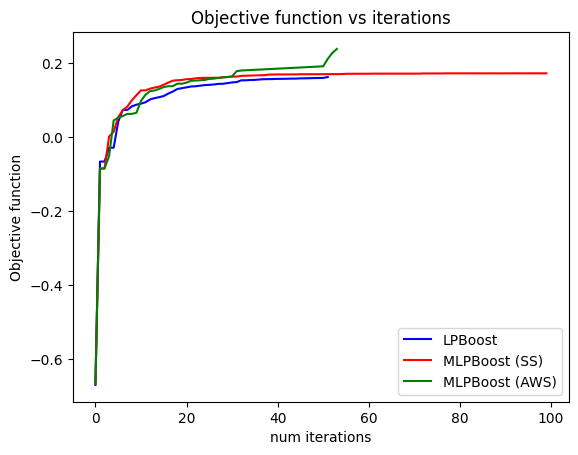

In [169]:
plt.plot(range(len(obj_f_lp)), obj_f_lp, c="blue", label="LPBoost")
plt.plot(range(len(obj_f_SS)), obj_f_SS, c="red", label ="MLPBoost (SS)")
plt.plot(range(len(obj_f_AWS)), obj_f_AWS, c="green", label = "MLPBoost (AWS)")
plt.legend(loc="best")
plt.title("Objective function vs iterations")
plt.xlabel("num iterations")
plt.ylabel("Objective function")
plt.show()

### Test error plots

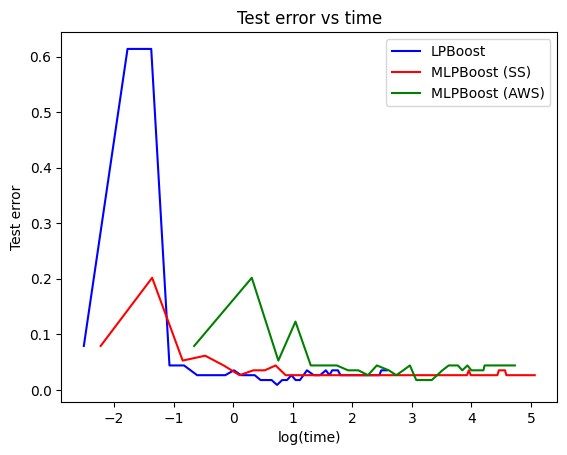

In [170]:
plt.plot(np.log(times_lp), err_test_lp, c="blue",label="LPBoost")
plt.plot(np.log(times_SS), err_test_SS, c="red", label ="MLPBoost (SS)")
plt.plot(np.log(times_AWS), err_test_AWS, c="green", label = "MLPBoost (AWS)")
plt.legend(loc="best")
plt.title("Test error vs time")
plt.xlabel("log(time)")
plt.ylabel("Test error")
plt.show()

### LPBoost calls vs number of iterations

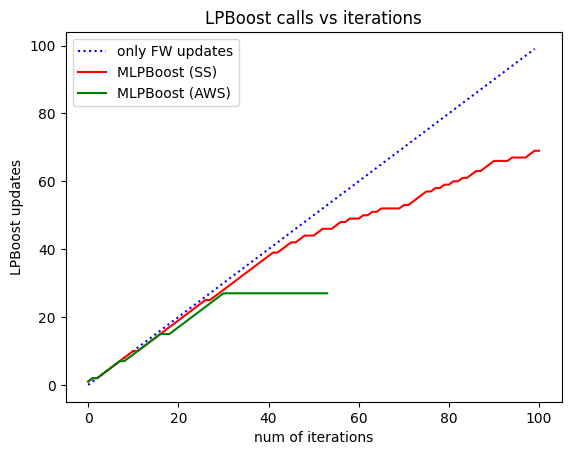

In [238]:
plt.plot(range(100), color="blue", linestyle="dotted", label = "only FW updates")
plt.plot(range(len(lp_calls_SS)), lp_calls_SS, color="red", label ="MLPBoost (SS)")
plt.plot(range(len(lp_calls_AWS)),lp_calls_AWS, color="green", label ="MLPBoost (AWS)")
plt.legend()
plt.title("LPBoost calls vs iterations")
plt.xlabel("num of iterations")
plt.ylabel("LPBoost updates")
plt.show()

### Impact of LPBoost updates

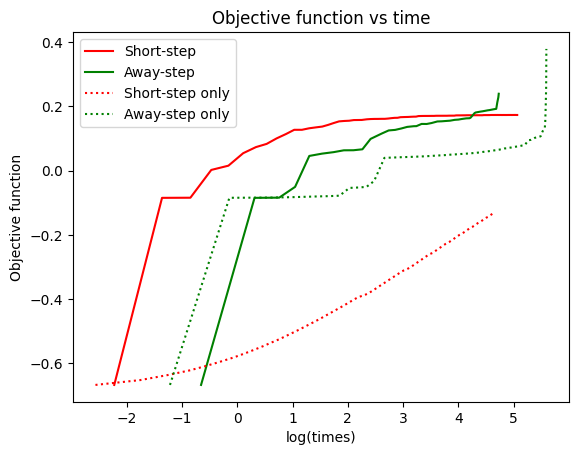

In [175]:
plt.plot(np.log(times_SS), obj_f_SS, c="red", label ="Short-step")
plt.plot(np.log(times_AWS), obj_f_AWS, c="green", label = "Away-step")
plt.plot(np.log(times_SS_only), obj_f_SS_only, c="red", linestyle="dotted", label = "Short-step only")
plt.plot(np.log(times_AWS_only), obj_f_AWS_only, c="green", linestyle="dotted", label = "Away-step only")
plt.legend(loc="best")
plt.title("Objective function vs time")
plt.xlabel("log(times)")
plt.ylabel("Objective function")
plt.show()

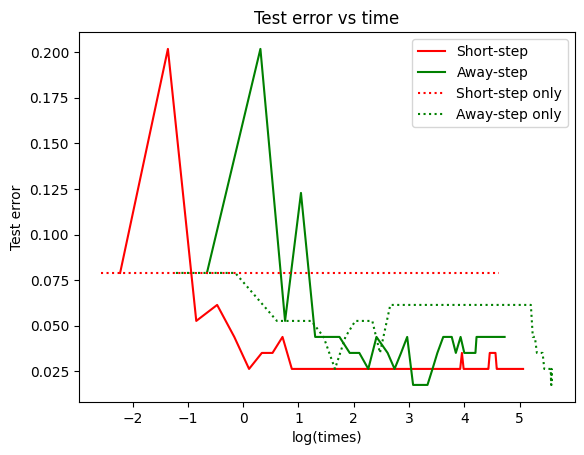

In [237]:
plt.plot(np.log(times_SS), err_test_SS, c="red", label ="Short-step")
plt.plot(np.log(times_AWS), err_test_AWS, c="green", label = "Away-step")
plt.plot(np.log(times_SS_only), err_test_SS_only, c="red", linestyle="dotted", label = "Short-step only")
plt.plot(np.log(times_AWS_only), err_test_AWS_only, c="green", linestyle="dotted", label = "Away-step only")
plt.legend(loc="best")
plt.title("Test error vs time")
plt.xlabel("log(times)")
plt.ylabel("Test error")
plt.show()